Investigation into a model which takes a mixed complex spectrogram (in the form of real numbered real and imaginary channels) and learns to produce a separated magnitude and phase spectrogram.

In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import importlib
from datetime import datetime

import audio_functions as af
import model_functions as mf
import audio_models
import dataset

Using TensorFlow backend.


In [2]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

In [3]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0001
phase_weight = 0.0005

#checkpoint = '52/52-10' #  Best U-net
checkpoint = '220/220-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Mixed'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Background'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)

mixed_input = mixed_spec[:, :, :-1, :]
voice_input = voice_spec[:, :, :-1, :]

data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

### Define and Build the Model

In [4]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, background_audio, 'unet', is_training, learning_rate, 
                                    'complex_to_magphase', phase_weight, name='Magnitude_Model')

Creating model


In [5]:
tf_config = tf.ConfigProto()
#tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

In [6]:
tf.trainable_variables()

[<tf.Variable 'Magnitude_Model/voice-mask-unet/encoder/layer-1/conv2d/kernel:0' shape=(5, 5, 2, 16) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/voice-mask-unet/encoder/layer-1/conv2d/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/voice-mask-unet/encoder/layer-2/conv2d/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/voice-mask-unet/encoder/layer-2/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/voice-mask-unet/encoder/layer-2/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/voice-mask-unet/encoder/layer-2/BatchNorm/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/voice-mask-unet/encoder/layer-3/conv2d/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/voice-mask-unet/encoder/layer-3/conv2d/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/voice-mask-unet/encoder/layer-3/BatchNorm/beta:0' 

In [7]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 1000
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        #_, cost = sess.run([model.train_op, model.cost], {model.is_training:True})
        _, cost, m_loss, p_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss], {model.is_training:True})
        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        epoch_m_loss.append(m_loss)
        epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
                                                                               empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))

start: 2018-11-22 09:09:46.324648
Epoch 0 finished. Mean cost = 0.004191405605524778
	Mean magnitude loss = 0.00769420713186264
	Mean phase loss = 0.0006886042538098991
Epoch 1 finished. Mean cost = 0.0041752399411052465
	Mean magnitude loss = 0.007662015501409769
	Mean phase loss = 0.0006884645263198763
Epoch 2 finished. Mean cost = 0.0041557711859544115
	Mean magnitude loss = 0.007623218931257725
	Mean phase loss = 0.0006883235570664207
Epoch 3 finished. Mean cost = 0.004136639181524515
	Mean magnitude loss = 0.007585066952742636
	Mean phase loss = 0.0006882115558255464
Epoch 4 finished. Mean cost = 0.004117376171052456
	Mean magnitude loss = 0.007546642795205116
	Mean phase loss = 0.0006881095934659243
Epoch 5 finished. Mean cost = 0.0040991635372241335
	Mean magnitude loss = 0.007510323620711763
	Mean phase loss = 0.0006880034343339503
Epoch 6 finished. Mean cost = 0.00408156422365989
	Mean magnitude loss = 0.0074752385595015115
	Mean phase loss = 0.000687889929395169
Epoch 7 finis

Epoch 60 finished. Mean cost = 0.003376257598216905
	Mean magnitude loss = 0.006069503182575839
	Mean phase loss = 0.0006830120024072831
Epoch 61 finished. Mean cost = 0.0033645126855962218
	Mean magnitude loss = 0.006046071295596419
	Mean phase loss = 0.0006829540671465258
Epoch 62 finished. Mean cost = 0.0033527461013623644
	Mean magnitude loss = 0.00602259591133112
	Mean phase loss = 0.0006828962812303669
Epoch 63 finished. Mean cost = 0.0033410523828933947
	Mean magnitude loss = 0.005999267108563799
	Mean phase loss = 0.0006828376472185482
Epoch 64 finished. Mean cost = 0.003329352783755614
	Mean magnitude loss = 0.005975924876446908
	Mean phase loss = 0.0006827806794227889
Epoch 65 finished. Mean cost = 0.0033177036693263235
	Mean magnitude loss = 0.005952684300471888
	Mean phase loss = 0.0006827230231878771
Epoch 66 finished. Mean cost = 0.0033061193100718863
	Mean magnitude loss = 0.005929572194981486
	Mean phase loss = 0.0006826664086556367
Epoch 67 finished. Mean cost = 0.0032

Epoch 121 finished. Mean cost = 0.0027697833148060277
	Mean magnitude loss = 0.004859811532860774
	Mean phase loss = 0.0006797551043850721
Epoch 122 finished. Mean cost = 0.0027621109568612364
	Mean magnitude loss = 0.0048445169075687486
	Mean phase loss = 0.0006797050132522193
Epoch 123 finished. Mean cost = 0.002754554672602324
	Mean magnitude loss = 0.004829460077152978
	Mean phase loss = 0.000679649276031752
Epoch 124 finished. Mean cost = 0.0027470009569078684
	Mean magnitude loss = 0.004814408028498292
	Mean phase loss = 0.0006795938941650092
Epoch 125 finished. Mean cost = 0.0027394778610739324
	Mean magnitude loss = 0.004799413398676921
	Mean phase loss = 0.0006795423327102547
Epoch 126 finished. Mean cost = 0.002732120359895795
	Mean magnitude loss = 0.004784752191301054
	Mean phase loss = 0.0006794885367404405
Epoch 127 finished. Mean cost = 0.0027247431680734735
	Mean magnitude loss = 0.004770050689330674
	Mean phase loss = 0.0006794356545469782
Epoch 128 finished. Mean cost

Epoch 181 finished. Mean cost = 0.002406096609774977
	Mean magnitude loss = 0.004135703375041076
	Mean phase loss = 0.0006764898518647917
Epoch 182 finished. Mean cost = 0.0024013745673560623
	Mean magnitude loss = 0.004126313670482384
	Mean phase loss = 0.0006764354721816063
Epoch 183 finished. Mean cost = 0.0023966791454965814
	Mean magnitude loss = 0.004116979635158635
	Mean phase loss = 0.000676378663426832
Epoch 184 finished. Mean cost = 0.00239200679824461
	Mean magnitude loss = 0.004107690917176975
	Mean phase loss = 0.0006763226865488733
Epoch 185 finished. Mean cost = 0.00238736188577448
	Mean magnitude loss = 0.004098458889050669
	Mean phase loss = 0.0006762648893830677
Epoch 186 finished. Mean cost = 0.002382723284003768
	Mean magnitude loss = 0.004089236939276125
	Mean phase loss = 0.0006762096358906418
Epoch 187 finished. Mean cost = 0.002378168710299391
	Mean magnitude loss = 0.004080182441728229
	Mean phase loss = 0.0006761549863013182
Epoch 188 finished. Mean cost = 0.0

Epoch 241 finished. Mean cost = 0.0021701677888054556
	Mean magnitude loss = 0.003667547281885381
	Mean phase loss = 0.0006727882993334427
Epoch 242 finished. Mean cost = 0.0021668579448551064
	Mean magnitude loss = 0.0036609979497782366
	Mean phase loss = 0.0006727179435250415
Epoch 243 finished. Mean cost = 0.00216359028508734
	Mean magnitude loss = 0.0036545287394041167
	Mean phase loss = 0.0006726518348260156
Epoch 244 finished. Mean cost = 0.002160347465007585
	Mean magnitude loss = 0.0036481129176610585
	Mean phase loss = 0.0006725820163930101
Epoch 245 finished. Mean cost = 0.002157124829842005
	Mean magnitude loss = 0.0036417358153598097
	Mean phase loss = 0.0006725138483466808
Epoch 246 finished. Mean cost = 0.002153912372981398
	Mean magnitude loss = 0.003635379893003929
	Mean phase loss = 0.0006724448572007208
Epoch 247 finished. Mean cost = 0.002150728854992908
	Mean magnitude loss = 0.003629077147061546
	Mean phase loss = 0.0006723805671490188
Epoch 248 finished. Mean cost

Epoch 301 finished. Mean cost = 0.0019991540840352015
	Mean magnitude loss = 0.0033294025207993064
	Mean phase loss = 0.0006689056520896119
Epoch 302 finished. Mean cost = 0.001996736261200639
	Mean magnitude loss = 0.0033246274628728725
	Mean phase loss = 0.0006688450643310182
Epoch 303 finished. Mean cost = 0.001994312563941716
	Mean magnitude loss = 0.0033198385614301323
	Mean phase loss = 0.0006687865710486413
Epoch 304 finished. Mean cost = 0.0019918895990694643
	Mean magnitude loss = 0.003315054455039198
	Mean phase loss = 0.0006687247478708503
Epoch 305 finished. Mean cost = 0.0019894830952550658
	Mean magnitude loss = 0.0033102998726094275
	Mean phase loss = 0.0006686663230366737
Epoch 306 finished. Mean cost = 0.001987103482022736
	Mean magnitude loss = 0.003305600689502633
	Mean phase loss = 0.0006686062798516806
Epoch 307 finished. Mean cost = 0.00198475211139091
	Mean magnitude loss = 0.003300955031874481
	Mean phase loss = 0.0006685491960099596
Epoch 308 finished. Mean cos

Epoch 360 finished. Mean cost = 0.0018728611861172433
	Mean magnitude loss = 0.0030800668426616495
	Mean phase loss = 0.0006656555344100391
Epoch 361 finished. Mean cost = 0.0018709622769235784
	Mean magnitude loss = 0.003076319384339744
	Mean phase loss = 0.0006656051744920463
Epoch 362 finished. Mean cost = 0.0018690864766560515
	Mean magnitude loss = 0.003072617876666698
	Mean phase loss = 0.0006655550817766589
Epoch 363 finished. Mean cost = 0.0018672119473634226
	Mean magnitude loss = 0.003068919746131012
	Mean phase loss = 0.000665504153393168
Epoch 364 finished. Mean cost = 0.0018653461208873211
	Mean magnitude loss = 0.003065238471066401
	Mean phase loss = 0.0006654537753329599
Epoch 365 finished. Mean cost = 0.0018634889128521248
	Mean magnitude loss = 0.003061573641995589
	Mean phase loss = 0.0006654041884797804
Epoch 366 finished. Mean cost = 0.0018616450467712831
	Mean magnitude loss = 0.0030579346496033247
	Mean phase loss = 0.0006653554485387572
Epoch 367 finished. Mean c

Epoch 420 finished. Mean cost = 0.00177276580132137
	Mean magnitude loss = 0.002882678148551289
	Mean phase loss = 0.0006628534558888375
Epoch 421 finished. Mean cost = 0.001771293393495135
	Mean magnitude loss = 0.002879774841254851
	Mean phase loss = 0.0006628119473906137
Epoch 422 finished. Mean cost = 0.0017698146270733353
	Mean magnitude loss = 0.0028768607525894723
	Mean phase loss = 0.0006627685033460864
Epoch 423 finished. Mean cost = 0.0017683376867833704
	Mean magnitude loss = 0.002873951237800285
	Mean phase loss = 0.0006627241378256893
Epoch 424 finished. Mean cost = 0.0017668492492178783
	Mean magnitude loss = 0.002871017125709092
	Mean phase loss = 0.0006626813746440937
Epoch 425 finished. Mean cost = 0.0017653662411325518
	Mean magnitude loss = 0.002868093673725713
	Mean phase loss = 0.0006626388101790432
Epoch 426 finished. Mean cost = 0.0017638990336012715
	Mean magnitude loss = 0.0028652012805112
	Mean phase loss = 0.0006625967884634728
Epoch 427 finished. Mean cost =

Epoch 479 finished. Mean cost = 0.0016929088851611596
	Mean magnitude loss = 0.0027253513554266343
	Mean phase loss = 0.0006604664161083444
Epoch 480 finished. Mean cost = 0.0016917200570755683
	Mean magnitude loss = 0.00272301228459452
	Mean phase loss = 0.0006604278305247271
Epoch 481 finished. Mean cost = 0.0016905349047460373
	Mean magnitude loss = 0.002720679641707078
	Mean phase loss = 0.000660390168871862
Epoch 482 finished. Mean cost = 0.0016893104835187796
	Mean magnitude loss = 0.0027182693665511676
	Mean phase loss = 0.0006603516018120322
Epoch 483 finished. Mean cost = 0.0016880715737304043
	Mean magnitude loss = 0.0027158300092632397
	Mean phase loss = 0.0006603131394002063
Epoch 484 finished. Mean cost = 0.0016868428353546668
	Mean magnitude loss = 0.0027134104382208328
	Mean phase loss = 0.0006602752338086745
Epoch 485 finished. Mean cost = 0.0016856145170237487
	Mean magnitude loss = 0.0027109913016792097
	Mean phase loss = 0.0006602377336857449
Epoch 486 finished. Mean

Epoch 539 finished. Mean cost = 0.0016250389175386064
	Mean magnitude loss = 0.0025917481098548267
	Mean phase loss = 0.0006583297272704335
Epoch 540 finished. Mean cost = 0.001623994495216998
	Mean magnitude loss = 0.00258969264376096
	Mean phase loss = 0.0006582963485021123
Epoch 541 finished. Mean cost = 0.0016229613334012676
	Mean magnitude loss = 0.002587659219821152
	Mean phase loss = 0.0006582634488070845
Epoch 542 finished. Mean cost = 0.0016219359153665561
	Mean magnitude loss = 0.0025856414079600963
	Mean phase loss = 0.0006582304245953553
Epoch 543 finished. Mean cost = 0.0016209322756741825
	Mean magnitude loss = 0.002583666298639454
	Mean phase loss = 0.0006581982544209014
Epoch 544 finished. Mean cost = 0.00161991101804984
	Mean magnitude loss = 0.0025816568064529004
	Mean phase loss = 0.0006581652312488253
Epoch 545 finished. Mean cost = 0.001618878235324071
	Mean magnitude loss = 0.0025796234723258994
	Mean phase loss = 0.0006581330000279614
Epoch 546 finished. Mean cos

Epoch 599 finished. Mean cost = 0.0015676884828523423
	Mean magnitude loss = 0.002478921188934085
	Mean phase loss = 0.0006564557800690333
Epoch 600 finished. Mean cost = 0.001566806914069428
	Mean magnitude loss = 0.002477187266807303
	Mean phase loss = 0.0006564265645276476
Epoch 601 finished. Mean cost = 0.001565935410616418
	Mean magnitude loss = 0.002475473662549042
	Mean phase loss = 0.0006563971618745798
Epoch 602 finished. Mean cost = 0.0015650605898702619
	Mean magnitude loss = 0.00247375339298211
	Mean phase loss = 0.000656367789943908
Epoch 603 finished. Mean cost = 0.0015641765856717572
	Mean magnitude loss = 0.002472014945472239
	Mean phase loss = 0.0006563382290514951
Epoch 604 finished. Mean cost = 0.0015632924821982084
	Mean magnitude loss = 0.0024702756592526664
	Mean phase loss = 0.0006563093085111358
Epoch 605 finished. Mean cost = 0.0015624099706527054
	Mean magnitude loss = 0.0024685395851565322
	Mean phase loss = 0.0006562803595107073
Epoch 606 finished. Mean cost

Epoch 659 finished. Mean cost = 0.001518361443286818
	Mean magnitude loss = 0.0023819275600765128
	Mean phase loss = 0.0006547953296720868
Epoch 660 finished. Mean cost = 0.001517610704743285
	Mean magnitude loss = 0.0023804523659103553
	Mean phase loss = 0.0006547690468344347
Epoch 661 finished. Mean cost = 0.001516854920525813
	Mean magnitude loss = 0.002378966726483693
	Mean phase loss = 0.0006547431179970851
Epoch 662 finished. Mean cost = 0.0015160897809894107
	Mean magnitude loss = 0.0023774626678162076
	Mean phase loss = 0.0006547168976743881
Epoch 663 finished. Mean cost = 0.0015153265696689375
	Mean magnitude loss = 0.002375962260019326
	Mean phase loss = 0.0006546908828250345
Epoch 664 finished. Mean cost = 0.0015145590327526057
	Mean magnitude loss = 0.0023744530695721617
	Mean phase loss = 0.0006546649992592016
Epoch 665 finished. Mean cost = 0.0015137962818316355
	Mean magnitude loss = 0.0023729535436408746
	Mean phase loss = 0.0006546390232561553
Epoch 666 finished. Mean 

Epoch 719 finished. Mean cost = 0.0014754055984667503
	Mean magnitude loss = 0.002297505772892489
	Mean phase loss = 0.0006533054284874299
Epoch 720 finished. Mean cost = 0.0014747414712428571
	Mean magnitude loss = 0.0022962006095063135
	Mean phase loss = 0.0006532823375811162
Epoch 721 finished. Mean cost = 0.001474088950500594
	Mean magnitude loss = 0.002294919570782828
	Mean phase loss = 0.0006532583348943215
Epoch 722 finished. Mean cost = 0.0014734262378981663
	Mean magnitude loss = 0.0022936172198560886
	Mean phase loss = 0.0006532352606097383
Epoch 723 finished. Mean cost = 0.0014727491594706944
	Mean magnitude loss = 0.0022922866162200825
	Mean phase loss = 0.000653211707303954
Epoch 724 finished. Mean cost = 0.0014720781063982124
	Mean magnitude loss = 0.0022909685887460567
	Mean phase loss = 0.0006531876285464086
Epoch 725 finished. Mean cost = 0.00147141466884471
	Mean magnitude loss = 0.0022896651754902354
	Mean phase loss = 0.0006531641668493836
Epoch 726 finished. Mean c

Epoch 778 finished. Mean cost = 0.001438168277476815
	Mean magnitude loss = 0.0022243799186528056
	Mean phase loss = 0.0006519566413818528
Epoch 779 finished. Mean cost = 0.001437562851396461
	Mean magnitude loss = 0.002223190790316902
	Mean phase loss = 0.000651934917550534
Epoch 780 finished. Mean cost = 0.001436960898195459
	Mean magnitude loss = 0.002222008967686268
	Mean phase loss = 0.0006519128336981368
Epoch 781 finished. Mean cost = 0.001436364335303321
	Mean magnitude loss = 0.0022208369737479103
	Mean phase loss = 0.000651891701771399
Epoch 782 finished. Mean cost = 0.0014357657612171762
	Mean magnitude loss = 0.002219661616804709
	Mean phase loss = 0.0006518699106103759
Epoch 783 finished. Mean cost = 0.0014351644348032412
	Mean magnitude loss = 0.002218480578597578
	Mean phase loss = 0.0006518482959832835
Epoch 784 finished. Mean cost = 0.0014345596510335612
	Mean magnitude loss = 0.002217292785051332
	Mean phase loss = 0.0006518265219838329
Epoch 785 finished. Mean cost =

Epoch 837 finished. Mean cost = 0.0014047091796234037
	Mean magnitude loss = 0.0021586954805651024
	Mean phase loss = 0.0006507228826409371
Epoch 838 finished. Mean cost = 0.0014041826671907396
	Mean magnitude loss = 0.002157662034004758
	Mean phase loss = 0.0006507033043312347
Epoch 839 finished. Mean cost = 0.001403648172812869
	Mean magnitude loss = 0.0021566131886737866
	Mean phase loss = 0.0006506831609710519
Epoch 840 finished. Mean cost = 0.0014031054512968599
	Mean magnitude loss = 0.0021555476506904
	Mean phase loss = 0.0006506632559176415
Epoch 841 finished. Mean cost = 0.0014025679079654257
	Mean magnitude loss = 0.002154492553834518
	Mean phase loss = 0.000650643266036757
Epoch 842 finished. Mean cost = 0.0014020411190930379
	Mean magnitude loss = 0.0021534587995702685
	Mean phase loss = 0.0006506234425515564
Epoch 843 finished. Mean cost = 0.0014015193582403195
	Mean magnitude loss = 0.002152435102646782
	Mean phase loss = 0.0006506036178339096
Epoch 844 finished. Mean cos

Epoch 896 finished. Mean cost = 0.0013746146654913672
	Mean magnitude loss = 0.002099628704433914
	Mean phase loss = 0.0006496006303774183
Epoch 897 finished. Mean cost = 0.001374126395834444
	Mean magnitude loss = 0.0020986701370131863
	Mean phase loss = 0.0006495826584800356
Epoch 898 finished. Mean cost = 0.0013736374620545047
	Mean magnitude loss = 0.002097710166271523
	Mean phase loss = 0.0006495647616575662
Epoch 899 finished. Mean cost = 0.001373148993977035
	Mean magnitude loss = 0.002096751576496495
	Mean phase loss = 0.0006495464152087354
Epoch 900 finished. Mean cost = 0.0013726609081989123
	Mean magnitude loss = 0.002095793407476537
	Mean phase loss = 0.0006495284127328879
Epoch 901 finished. Mean cost = 0.001372183064936336
	Mean magnitude loss = 0.002094855646916692
	Mean phase loss = 0.0006495104868278865
Epoch 902 finished. Mean cost = 0.0013717177347460573
	Mean magnitude loss = 0.002093943033046641
	Mean phase loss = 0.0006494924403775529
Epoch 903 finished. Mean cost

Epoch 955 finished. Mean cost = 0.0013474672366051534
	Mean magnitude loss = 0.0020463527154682055
	Mean phase loss = 0.0006485817613953015
Epoch 956 finished. Mean cost = 0.0013470302496247516
	Mean magnitude loss = 0.0020454950264996636
	Mean phase loss = 0.0006485654763992226
Epoch 957 finished. Mean cost = 0.0013465938438556404
	Mean magnitude loss = 0.00204463874605739
	Mean phase loss = 0.000648548945360224
Epoch 958 finished. Mean cost = 0.0013461716524572952
	Mean magnitude loss = 0.002043810457586504
	Mean phase loss = 0.000648532851091251
Epoch 959 finished. Mean cost = 0.0013457427889079555
	Mean magnitude loss = 0.0020429690682552365
	Mean phase loss = 0.0006485165132592859
Epoch 960 finished. Mean cost = 0.0013453058960714787
	Mean magnitude loss = 0.002042111650067619
	Mean phase loss = 0.0006485001458306714
Epoch 961 finished. Mean cost = 0.0013448649487582088
	Mean magnitude loss = 0.0020412461598124936
	Mean phase loss = 0.0006484837413948463
Epoch 962 finished. Mean c

### Run a batch

In [8]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, mask, voice_wave, mix_wave = sess.run([model.mixed_input, 
                                                                                 model.mixed_phase, 
                                                                                 model.voice_input,
                                                                                 model.gen_voice, 
                                                                                 model.voice_mask, 
                                                                                 model.voice_audio, 
                                                                                 model.mixed_audio],
                                                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(voice_est[i, :, :, 1]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)

### Visualise and Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [9]:
i=0
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

1
65280


In [10]:
# Infer the background noise and background noise estimate by subtracting the voice and voice estimate from the mixture
# Normalise audio prior to subtraction
def normalise_audio(audio):
    norm_audio = 2*((audio - audio.min())/(audio.max()-audio.min())) - 1
    return norm_audio

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = normalise_audio(mix_wave[i,:,:])

bg_ref_wave = mix_wave - voice_wave
bg_est_wave = mix_wave - voice_est_wave

In [11]:
# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(len(voice_est_wave)):
    ref_sources.append(np.concatenate((voice_wave[i], bg_ref_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[10.81433505 13.88210882]] 
SIR
 [[16.20084044 24.03827415]] 
SAR
 [[12.40040646 14.33977778]] 
NSDR
 [[ 7.6830611  12.12352201]]


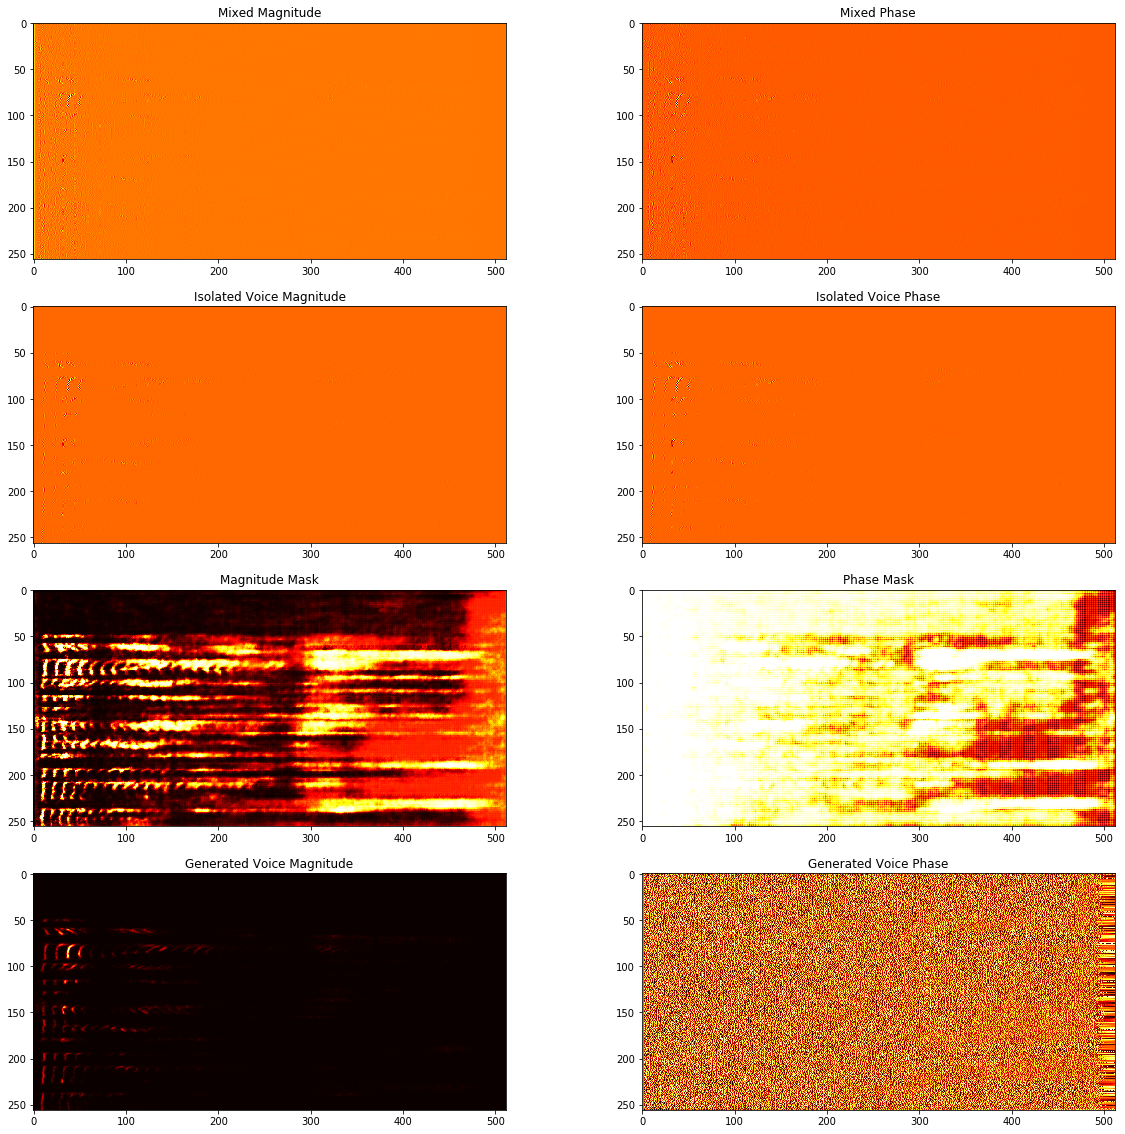

In [12]:
i=0

fig, ax = plt.subplots(4,2, figsize=(20,20))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('Mixed Magnitude')
ax[0,1].imshow(mix_inp[i,:,:,1])
ax[0,1].set_title('Mixed Phase')
ax[1,0].imshow(voice_inp[i,:,:,0])
ax[1,0].set_title('Isolated Voice Magnitude')
ax[1,1].imshow(voice_inp[i,:,:,1])
ax[1,1].set_title('Isolated Voice Phase')
ax[2,0].imshow(mask[i,:,:,0])
ax[2,0].set_title('Magnitude Mask')
ax[2,1].imshow(mask[i,:,:,1])
ax[2,1].set_title('Phase Mask')
ax[3,0].imshow(voice_est[i,:,:,0])
ax[3,0].set_title('Generated Voice Magnitude')
ax[3,1].imshow(voice_est[i,:,:,1])
ax[3,1].set_title('Generated Voice Phase')
#plt.savefig(os.path.join(folder, 'mag_phase_example_2.png'))
plt.show()

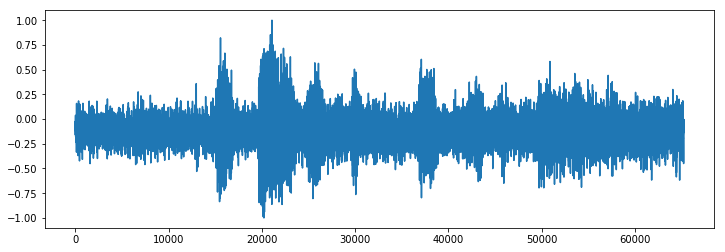

In [13]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

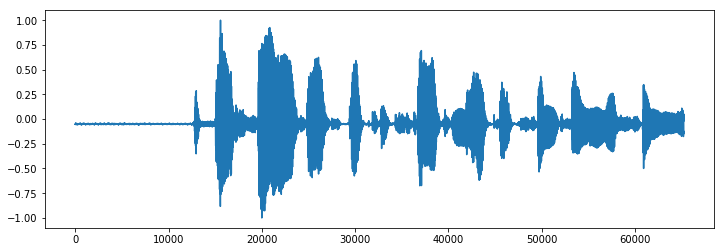

In [14]:
#  The original isolated voice
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

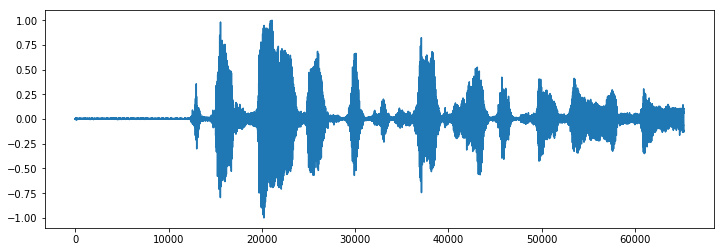

In [15]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)